# Mini Spark Broker: Early classification and external database

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-06


The purpose of this notebook is to test Spark capability to connect to external database such as the CDS at Strasbourg.

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* http://cdsxmatch.u-strasbg.fr/xmatch/doc/index.html

In [198]:
from pyspark.sql import SparkSession

import io
import time
import requests

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from lsst.msb import avroUtils
from lsst.msb.filtering import make_dataframe_from_alerts
from lsst.msb.filtering import extract_history_ztf

## Step 0: Running the LSST alert system

In order to play with this notebook, you need to create the stream of alerts. see the README file of the bootcamp to set up your environment and launch the stream.

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, let's initialise the Spark context:

In [2]:
# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("filtering") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "ztf-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: Filtering the stream

In this section, we will design simple fiters to interact with the stream and extract only relevant information for us. Let's first create a sink and grab all the alerts:

In [4]:
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [5]:
# Give a bit of time for synchronisation
time.sleep(10)

In [6]:
# Construct your DataFrame with data from Kafka
df_raw = spark.sql("select * from qraw")
df_raw.show(10)

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     0|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     1|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     2|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     3|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     4|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     5|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     6|2019-02-06 09:26:...|            0|
|null|[06 33 2E 32 32 5...|ztf-stream|        0|     7|2019-02-06 09:26:...|            0|

We can look closely at the columns of this Dataframe:

In [7]:
df_raw.printSchema()
df_raw.describe().show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------+----------+---------+------------------+-------------+
|summary|     topic|partition|            offset|timestampType|
+-------+----------+---------+------------------+-------------+
|  count|       499|      499|               499|          499|
|   mean|      null|      0.0|             249.0|          0.0|
| stddev|      null|      0.0|144.19315748906627|          0.0|
|    min|ztf-stream|        0|                 0|            0|
|    max|ztf-stream|        0|               498|            0|
+-------+----------+---------+------------------+-------------+



The column of interest for us is `value` which contains the alert data. For the moment, the data is `binary`, so let's decode it. First read the corresponding schema (ZTF in this example):

In [8]:
# Read the schema
alert_schema = avroUtils.readSchemaFromAvroFile("../schemas/template_schema_ZTF.avro")

# Broadcast the schema to all Spark executors
# (Keep in mind we work in a distributed environment!)
sc.broadcast(alert_schema)

# Look at the available keys
print(alert_schema.keys())

dict_keys(['type', 'version', 'name', 'namespace', 'fields', 'doc'])


Now we have the schema, we can decode the alerts. For technical reason, you need to go to RDD world to use in a meaningful way the decoder:

In [9]:
# RDD: Resilient Distributed Dataset.
# Both Spark DataFrames and RDDs are distributed memory abstractions, fault-tolerant and immutable.
# The main difference is that Dataframes are organized into named columns with defined 
# data types and including the benefits of Spark SQL's execution engine.
# Historically, there were only RDDs. DataFrame came later in Spark.
rdd_alerts = df_raw.select("value").rdd.map(lambda x: avroUtils.decoder(x.value, alert_schema))

And here is one full alert:

In [10]:
rdd_alerts.take(1)

[{'schemavsn': '3.2',
  'publisher': 'ZTF (www.ztf.caltech.edu)',
  'objectId': 'ZTF18abyouwp',
  'candid': 697251920015010010,
  'candidate': {'jd': 2458451.7519213,
   'fid': 1,
   'pid': 697251920015,
   'diffmaglim': 19.647123336791992,
   'pdiffimfilename': 'ztf_20181129251771_000248_zg_c01_o_q1_scimrefdiffimg.fits',
   'programpi': 'Kulkarni',
   'programid': 1,
   'candid': 697251920015010010,
   'isdiffpos': 'f',
   'tblid': 10,
   'nid': 697,
   'rcid': 0,
   'field': 248,
   'xpos': 1817.9852294921875,
   'ypos': 2753.298828125,
   'ra': 26.8566983,
   'dec': -26.9677112,
   'magpsf': 14.283452987670898,
   'sigmapsf': 0.038736678659915924,
   'chipsf': 50.48195266723633,
   'magap': 14.340100288391113,
   'sigmagap': 0.008100000210106373,
   'distnr': 0.24791085720062256,
   'magnr': 12.048999786376953,
   'sigmagnr': 0.012000000104308128,
   'chinr': 0.6589999794960022,
   'sharpnr': 0.032999999821186066,
   'sky': 0.5009307861328125,
   'magdiff': 0.05664699897170067,
   '

### Calling Simbad

toto

Let's build a DataFrame with some selected entries:

In [210]:
colnames = [
    "candidate:ra", 
    "candidate:dec",
    "objectId"]
df_simple = make_dataframe_from_alerts(rdd_alerts, colnames)
df_simple.show(10)

+------------+-------------+------------+
|candidate:ra|candidate:dec|    objectId|
+------------+-------------+------------+
|  26.8566983|  -26.9677112|ZTF18abyouwp|
|    26.24497|  -26.7569436|ZTF18acsbjqe|
|  26.1126147|  -26.8053928|ZTF18acaixum|
|  25.5844032|  -27.9239037|ZTF18acsbjqg|
|  25.5902591|  -27.9131274|ZTF18acsbjqi|
|  26.0145383|  -27.9003972|ZTF18acsbjqf|
|  25.6648433|  -27.8417869|ZTF18acsbjqh|
|  24.4538066|  -27.0766656|ZTF18acsbjou|
|  24.9350326|  -26.5438418|ZTF18abvdmcb|
|   23.517342|  -27.0446981|ZTF18acsbjpf|
+------------+-------------+------------+
only showing top 10 rows



Let's first inspect output from cdsxmatch

In [203]:
table = """ra_in,dec_in
7.465000,38.324167
9.805417,3.134167
10.665417,71.366944
233.190417,68.866667
"""

r = requests.post(
         'http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync',
         data={'request': 'xmatch', 'distMaxArcsec': 5, 'RESPONSEFORMAT': 'csv',
         'cat2': 'simbad', 'colRA1': 'ra_in', 'colDec1': 'dec_in'},
         files={'cat1': table})

h = open('results.csv', 'w')
h.write(r.text)
h.close()

In [248]:
data = pd.DataFrame([np.array(i.split(",")) for i in r.content.decode().split("\n")])
data.transpose()

,0,1,2,3,4,5,6
0,angDist,0.745488,1.010772,1.357510,4.120559,4.364699,
1,ra_in,7.465,9.805417,10.665417,10.665417,10.665417,None
2,dec_in,38.324167,3.134167,71.366944,71.366944,71.366944,None
3,main_id,HD 2611,HD 3628,BD+70 39B,HD 3891,BD+70 39A,None
4,ra,7.4652624005,9.8052720833,10.6647407637,10.6668410096,10.6669583333,None
5,dec,+38.3241445286,+3.1339263889,+71.3672530503,+71.3658937187,+71.3658361111,None
6,coo_err_maj,0.000,0.000,0.000,0.007,0.032,None
7,coo_err_min,0.000,0.000,0.000,0.007,0.029,None
8,coo_err_angle,90,90,90,90,0,None
9,nbref,13,107,8,16,3,None


In [263]:
def cross_match_alerts(part):
    """ Query the CDSXmatch service to find know counterparts
    
    Parameters
    ----------
    part: Iterator
        Spark partition containing ra, dec and 
    
    Returns
    ----------
    out: Generator of tuples 
        Tuple with (objectId, ra, dec, name, type).
        If the object is not found in Simbad, name & type
        are marked as Unknown. In the case several objects are
        found, only the closest is returned.
    """
    data = [*part]
    ra, dec, oid = np.transpose(data)
    def generate_csv(s, x, y):
        """ Insert (x[i],y[i]) rows recursively in s.
        
        Parameters
        ----------
        s: str
            String which will contain the data.
            Should initially contain the CSV header.
        x: list
            List of whatever
        y: list
            Antoher list of whatever of the same size as x.
            
        Returns
        ----------
        s: str
            Updated string with one row per line.
        """
        if len(x) > 0:
            s = s + "{},{}\n ".format(x[0], y[0])
            return generate_csv(s, x[1:], y[1:])
        else:
            return s
    
    a = """ra_in,dec_in\n"""
    table = generate_csv(a, ra, dec)
    r = requests.post(
         'http://cdsxmatch.u-strasbg.fr/xmatch/api/v1/sync',
         data={
             'request': 'xmatch', 
             'distMaxArcsec': 1, 
             'selection': 'best',
             'RESPONSEFORMAT': 'csv',
             'cat2': 'simbad', 
             'colRA1': 'ra_in', 
             'colDec1': 'dec_in'},
         files={'cat1': table})

    # Need to find a less ugly way...
    h = open('results.csv', 'w')
    h.write(r.text)
    h.close()
    
    # Decode the message, and split line by line
    # First line is header - last is empty
    data = r.content.decode().split("\n")[1:-1]
    header = r.content.decode().split("\n")[0].split(",")
    
    # Indices
    main_id = header.index("main_id")
    main_type = header.index("main_type")
    ra_ind = header.index("ra_in")
    dec_ind = header.index("dec_in")
    
    # Get the (ra, dec) of matches
    radec_out = [
        (float(np.array(i.split(","))[ra_ind]), 
         float(np.array(i.split(","))[dec_ind])) for i in data]
    
    # Get the names of matches
    names = [np.array(i.split(","))[main_id] for i in data]
    
    # Get the types of matches
    types = [np.array(i.split(","))[main_type] for i in data]
    
    # Assign names and types to inputs
    out = []
    for ra_in, dec_in, id_in in zip(ra, dec, oid):
        # cast for picky Spark
        ra_in, dec_in = float(ra_in), float(dec_in)
        id_in = str(id_in)
        if (ra_in, dec_in) in radec_out:
            # Return the closest object in case of many (smallest angular distance)
            index = radec_out.index((ra_in, dec_in))
            out.append((id_in, ra_in, dec_in, str(names[index]), str(types[index])))
        else:
            # Mark as unknown if no match
            out.append((id_in, ra_in, dec_in, "Unknown", "Unknown"))
    
    yield out

colnames = ["objectId", "candidate:ra", "candidate:dec", "Simbad name", "Simbad type"]
df_type = df_simple.rdd\
    .mapPartitions(lambda x: cross_match_alerts(x))\
    .flatMap(lambda x: x)\
    .toDF(colnames)

df_type.show(10)

+------------+------------+-------------+--------------------+-----------+
|    objectId|candidate:ra|candidate:dec|         Simbad name|Simbad type|
+------------+------------+-------------+--------------------+-----------+
|ZTF18abyouwp|  26.8566983|  -26.9677112|      TYC 6431-115-1|       Star|
|ZTF18acsbjqe|    26.24497|  -26.7569436|             Unknown|    Unknown|
|ZTF18acaixum|  26.1126147|  -26.8053928|             Unknown|    Unknown|
|ZTF18acsbjqg|  25.5844032|  -27.9239037|             Unknown|    Unknown|
|ZTF18acsbjqi|  25.5902591|  -27.9131274|             Unknown|    Unknown|
|ZTF18acsbjqf|  26.0145383|  -27.9003972|             Unknown|    Unknown|
|ZTF18acsbjqh|  25.6648433|  -27.8417869|             Unknown|    Unknown|
|ZTF18acsbjou|  24.4538066|  -27.0766656|             Unknown|    Unknown|
|ZTF18abvdmcb|  24.9350326|  -26.5438418|CRTS J013944.5-26...|      RRLyr|
|ZTF18acsbjpf|   23.517342|  -27.0446981|             Unknown|    Unknown|
+------------+-----------

In [264]:
df_group = df_type.groupBy("Simbad type").count()

In [265]:
df_group.show()

# Check we did not miss alerts
assert(df_simple.count() == np.sum(df_group.select("count").rdd.collect()))

+-------------+-----+
|  Simbad type|count|
+-------------+-----+
|        GinCl|    1|
|          AGN|    1|
|   PulsV*WVir|    1|
|Candidate_EB*|    1|
|      EB*WUMa|   16|
|        AMHer|    1|
|      Unknown|  384|
|          HB*|    6|
|AGN_Candidate|    1|
|         Blue|    1|
|    Seyfert_1|    3|
|    EB*betLyr|    1|
|         LPV*|    1|
|        BLLac|    2|
|          QSO|    2|
|         Star|   26|
|        RRLyr|   51|
+-------------+-----+



In [266]:
pandas_df = df_group.toPandas()

Text(0.5,0,'Alert entry')

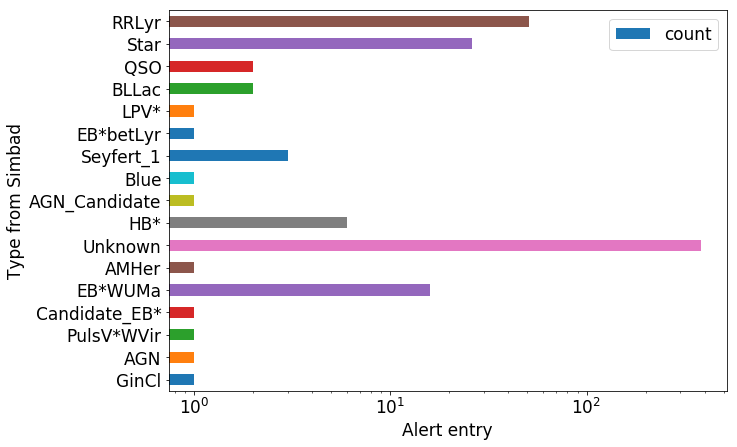

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pandas_df.plot("Simbad type", "count", kind="barh", ax=ax)
ax.set_xscale("log")
ax.set_ylabel("Type from Simbad")
ax.set_xlabel("Alert entry")